

1.   paquetes necesarios


In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


#cargar datos

In [2]:
# Cargar el Dataset de Abandono de Clientes de Telco
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("="*60)
print("ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL")
print("="*60)
print(f"\nForma del Dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nDistribución de Abandono:")
print(df['Churn'].value_counts())
print(f"\nInformación del Dataset:")
print(df.info())

ABANDONO DE CLIENTES TELCO - ENTRENAMIENTO RED NEURONAL

Forma del Dataset: (7043, 21)

Primeras filas:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic

# Task
Preprocesar el dataset `Telco-Customer-Churn.csv`, dividirlo en conjuntos de entrenamiento y prueba, entrenar un modelo de Regresión Logística y evaluar su rendimiento.

## Preprocesamiento de datos

### Subtask:
Limpiar los datos, manejar valores nulos, codificar variables categóricas y escalar características numéricas.


**Reasoning**:
The first step in data preprocessing is to convert the 'TotalCharges' column to a numeric type. This is crucial because the column is currently an object type, and it should contain numerical values for analysis and model training. Some values might not be convertible directly to numbers, so these should be replaced with NaN, which will be handled in the next step.



**Reasoning**:
The previous cell failed because the `pandas` library was not imported and the `df` DataFrame was not loaded, resulting in a `NameError`. To fix this, I will include the necessary `import pandas as pd` statement and the code to load the `df` DataFrame from the URL, ensuring that the cell has all required dependencies to execute successfully and convert the 'TotalCharges' column to a numeric type.



In [3]:
import pandas as pd

# Cargar el Dataset de Abandono de Clientes de Telco
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Convertido 'TotalCharges' a tipo numérico (NaN para errores).")
print(f"Tipo de 'TotalCharges' después de la conversión: {df['TotalCharges'].dtype}")

Convertido 'TotalCharges' a tipo numérico (NaN para errores).
Tipo de 'TotalCharges' después de la conversión: float64


**Reasoning**:
Now that 'TotalCharges' has been converted to a numeric type with `NaN` values for errors, the next step is to handle these missing values by filling them with the mean of the column to maintain data integrity and prevent issues during model training.



In [4]:
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
print("Valores nulos en 'TotalCharges' rellenados con la media.")
print(f"Número de valores nulos en 'TotalCharges' después de rellenar: {df['TotalCharges'].isnull().sum()}")

Valores nulos en 'TotalCharges' rellenados con la media.
Número de valores nulos en 'TotalCharges' después de rellenar: 0


**Reasoning**:
The previous code produced a `FutureWarning` related to using `inplace=True` with chained assignment. To address this and follow best practices, I will modify the code to assign the result of the `fillna` operation directly back to the column, which achieves the same outcome without the warning.



In [5]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())
print("Valores nulos en 'TotalCharges' rellenados con la media.")
print(f"Número de valores nulos en 'TotalCharges' después de rellenar: {df['TotalCharges'].isnull().sum()}")

Valores nulos en 'TotalCharges' rellenados con la media.
Número de valores nulos en 'TotalCharges' después de rellenar: 0


**Reasoning**:
Following the data preprocessing steps, the next action is to standardize categorical features by replacing specific values like 'No phone service' and 'No internet service' with a simpler 'No'. This ensures consistency and simplifies subsequent encoding steps.



In [6]:
for col in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

print("Valores 'No phone service' y 'No internet service' reemplazados por 'No' en las columnas relevantes.")

Valores 'No phone service' y 'No internet service' reemplazados por 'No' en las columnas relevantes.


**Reasoning**:
As part of cleaning the data and preparing it for modeling, the 'customerID' column should be removed because it is a unique identifier for each customer and does not provide predictive power for the churn classification task.



In [7]:
df = df.drop('customerID', axis=1)
print("Columna 'customerID' eliminada.")

Columna 'customerID' eliminada.


**Reasoning**:
The next step is to encode binary categorical columns into numerical values (0 and 1), which is essential for preparing the data for model training. The `LabelEncoder` from `sklearn.preprocessing` is suitable for this task as it handles binary conversions efficiently.



In [8]:
from sklearn.preprocessing import LabelEncoder

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(f"Columna '{col}' codificada: {le.classes_} -> {np.unique(df[col])}")

print("Columnas binarias codificadas a 0 y 1.")

Columna 'gender' codificada: ['Female' 'Male'] -> [0 1]
Columna 'Partner' codificada: ['No' 'Yes'] -> [0 1]
Columna 'Dependents' codificada: ['No' 'Yes'] -> [0 1]
Columna 'PhoneService' codificada: ['No' 'Yes'] -> [0 1]
Columna 'MultipleLines' codificada: ['No' 'Yes'] -> [0 1]
Columna 'OnlineSecurity' codificada: ['No' 'Yes'] -> [0 1]
Columna 'OnlineBackup' codificada: ['No' 'Yes'] -> [0 1]
Columna 'DeviceProtection' codificada: ['No' 'Yes'] -> [0 1]
Columna 'TechSupport' codificada: ['No' 'Yes'] -> [0 1]
Columna 'StreamingTV' codificada: ['No' 'Yes'] -> [0 1]
Columna 'StreamingMovies' codificada: ['No' 'Yes'] -> [0 1]
Columna 'PaperlessBilling' codificada: ['No' 'Yes'] -> [0 1]
Columna 'Churn' codificada: ['No' 'Yes'] -> [0 1]
Columnas binarias codificadas a 0 y 1.


**Reasoning**:
After encoding binary categorical columns, the next step is to apply One-Hot Encoding to the remaining non-binary categorical columns. This is crucial for converting them into a format suitable for machine learning models, which typically require numerical input.



In [9]:
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=categorical_cols, dtype=int)

print("Columnas categóricas restantes codificadas con One-Hot Encoding.")
print(f"Nuevas columnas después de One-Hot Encoding: {df.columns.difference(binary_cols)}")

Columnas categóricas restantes codificadas con One-Hot Encoding.
Nuevas columnas después de One-Hot Encoding: Index(['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'MonthlyCharges',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen', 'TotalCharges', 'tenure'],
      dtype='object')


**Reasoning**:
The final step in data preprocessing, as per the instructions, is to scale the numerical features ('tenure', 'MonthlyCharges', 'TotalCharges') using `StandardScaler`. This helps ensure that features with larger values do not dominate the learning process and improves the performance of many machine learning algorithms.



In [10]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Características numéricas escaladas con StandardScaler.")
print(f"Primeras filas del DataFrame con características escaladas:\n{df[numerical_cols].head()}")

Características numéricas escaladas con StandardScaler.
Primeras filas del DataFrame con características escaladas:
     tenure  MonthlyCharges  TotalCharges
0 -1.277445       -1.160323     -0.994971
1  0.066327       -0.259629     -0.173876
2 -1.236724       -0.362660     -0.960399
3  0.514251       -0.746535     -0.195400
4 -1.236724        0.197365     -0.941193


**Reasoning**:
The `ValueError: could not convert string to float: ' '` indicates that despite previous attempts to convert 'TotalCharges' to numeric, there are still non-numeric string values (specifically a single space) present in one of the numerical columns. This is a common issue with the 'TotalCharges' column in this dataset. To robustly address this, I will explicitly replace any ' ' (space string) with `np.nan` and ensure the column is of a numeric type before scaling, which should prevent the `ValueError` during `StandardScaler` application.



In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Re-clean TotalCharges to be absolutely sure, as the error suggests non-numeric values might still be present.
# This handles cases where ' ' might not have been correctly coerced to NaN initially, or was reintroduced.
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan) # Replace explicit spaces with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Coerce anything else that isn't numeric to NaN
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean()) # Fill any remaining NaNs with the mean

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Verify dtypes before scaling
print("Dtypes de las columnas numéricas antes de escalar:")
print(df[numerical_cols].dtypes)

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Características numéricas escaladas con StandardScaler.")
print(f"Primeras filas del DataFrame con características escaladas:\n{df[numerical_cols].head()}")

Dtypes de las columnas numéricas antes de escalar:
tenure            float64
MonthlyCharges    float64
TotalCharges      float64
dtype: object
Características numéricas escaladas con StandardScaler.
Primeras filas del DataFrame con características escaladas:
     tenure  MonthlyCharges  TotalCharges
0 -1.277445       -1.160323     -0.994971
1  0.066327       -0.259629     -0.173876
2 -1.236724       -0.362660     -0.960399
3  0.514251       -0.746535     -0.195400
4 -1.236724        0.197365     -0.941193


## División de datos

### Subtask:
Dividir el conjunto de datos en conjuntos de entrenamiento y prueba.


**Reasoning**:
The first step in dividing the data is to separate the features (X) from the target variable (y). The target variable is 'Churn', and all other columns will be considered features.



In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Características (X) y variable objetivo (y) separadas.")
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

Características (X) y variable objetivo (y) separadas.
Forma de X: (7043, 26)
Forma de y: (7043,)


**Reasoning**:
Now that the features (X) and target variable (y) are separated, the next logical step according to the instructions is to split them into training and testing sets. This is crucial for evaluating the model's performance on unseen data and preventing overfitting.



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos divididos en conjuntos de entrenamiento y prueba.")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

Datos divididos en conjuntos de entrenamiento y prueba.
Forma de X_train: (5634, 26)
Forma de X_test: (1409, 26)
Forma de y_train: (5634,)
Forma de y_test: (1409,)


## Entrenamiento del modelo de Regresión Logística

### Subtask:
Inicializar y entrenar un modelo de Regresión Logística con los datos preprocesados.


**Reasoning**:
The first step is to import the `LogisticRegression` class from `sklearn.linear_model` to prepare for model instantiation and training.



In [14]:
from sklearn.linear_model import LogisticRegression

print("LogisticRegression importado con éxito.")

LogisticRegression importado con éxito.


**Reasoning**:
Now that the `LogisticRegression` class is imported, the next logical step is to instantiate the model with the specified parameters (`solver='liblinear'`, `random_state=42`) and then train it using the `fit` method on the `X_train` and `y_train` datasets.



In [15]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

print("Modelo de Regresión Logística entrenado con éxito.")

Modelo de Regresión Logística entrenado con éxito.


## Evaluación del modelo

### Subtask:
Evaluar el rendimiento del modelo de Regresión Logística utilizando métricas apropiadas.


## Summary:

### Data Analysis Key Findings
*   **Data Preprocessing**:
    *   The 'TotalCharges' column was successfully converted to a numeric type, with `NaN` values filled by the mean. Initial non-numeric string values (`' '`) were identified and resolved through a re-cleaning step.
    *   Specific categorical values ('No phone service', 'No internet service') in relevant columns were consistently simplified to 'No'.
    *   The 'customerID' column was removed as it is not relevant for modeling.
    *   Binary categorical features were encoded to numerical 0s and 1s using `LabelEncoder`.
    *   Remaining non-binary categorical features were transformed using One-Hot Encoding (`pd.get_dummies`).
    *   Numerical features ('tenure', 'MonthlyCharges', 'TotalCharges') were successfully scaled using `StandardScaler` to standardize their range.
*   **Data Splitting**:
    *   The dataset was divided into features (`X`) and the target variable (`y`, 'Churn'). `X` contains 7043 samples with 26 features, and `y` contains 7043 labels.
    *   The data was split into training (80%) and testing (20%) sets, resulting in 5634 training samples and 1409 testing samples. The split was stratified by the 'Churn' variable to maintain class distribution in both sets.
*   **Model Training**:
    *   A Logistic Regression model was successfully initialized with `solver='liblinear'` and `random_state=42`.
    *   The model was trained using the preprocessed training data (`X_train` and `y_train`).

### Insights or Next Steps
*   The preprocessed dataset and trained Logistic Regression model are now ready for the next stage, which involves evaluating the model's performance.
*   The next step should focus on assessing the model's effectiveness using metrics like accuracy, precision, recall, F1-score, and ROC AUC on the unseen test data to understand its predictive capabilities for customer churn.


# Task
Generar predicciones de las etiquetas de clase y las probabilidades para el conjunto de prueba (X_test) utilizando el modelo de Regresión Logística entrenado.

## Generar Predicciones

### Subtask:
Generar las predicciones de las etiquetas de clase y las probabilidades para el conjunto de prueba (X_test) utilizando el modelo de Regresión Logística entrenado.


**Reasoning**:
To fulfill the subtask of generating predictions, I will use the trained Logistic Regression model to predict both class labels and class probabilities for the test set. This involves calling the `predict` method for class labels and `predict_proba` for class probabilities on `X_test`.



In [16]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Predicciones de etiquetas de clase y probabilidades generadas.")
print(f"Primeras 5 predicciones de clase: {y_pred[:5]}")
print(f"Primeras 5 probabilidades de clase positiva: {y_prob[:5]}")

Predicciones de etiquetas de clase y probabilidades generadas.
Primeras 5 predicciones de clase: [0 1 0 0 0]
Primeras 5 probabilidades de clase positiva: [0.04389589 0.68485534 0.0624611  0.39431733 0.02058553]


## Calcular y Mostrar Métricas de Evaluación

### Subtask:
Calcular e imprimir las métricas de rendimiento del modelo: Accuracy, F1-score, Precision, Recall y ROC-AUC, comparando las predicciones con los valores reales (y_test).


**Reasoning**:
To calculate the evaluation metrics, I need to import the required functions (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score) from `sklearn.metrics`.



In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Métricas de evaluación importadas con éxito.")

Métricas de evaluación importadas con éxito.


**Reasoning**:
Now that the necessary evaluation metrics are imported and predictions have been made, I will calculate and print the Accuracy, F1-score, Precision, Recall, and ROC-AUC using the `y_test`, `y_pred`, and `y_prob` variables, as instructed by the subtask.



In [18]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8034
F1-score: 0.6003
Precision: 0.6520
Recall: 0.5561
ROC-AUC: 0.8422


## Visualizar Matriz de Confusión

### Subtask:
Generar y mostrar una matriz de confusión para visualizar el rendimiento de clasificación del modelo.


**Reasoning**:
To visualize the model's performance, the first step is to import the `confusion_matrix` function from `sklearn.metrics` as specified in the instructions.



In [19]:
from sklearn.metrics import confusion_matrix

print("confusion_matrix importada con éxito.")

confusion_matrix importada con éxito.


**Reasoning**:
Now that `confusion_matrix` is imported, I will calculate the confusion matrix using `y_test` and `y_pred`, and then use `seaborn` and `matplotlib.pyplot` to visualize it as a heatmap with annotations, labels, and a title, as specified in the instructions.



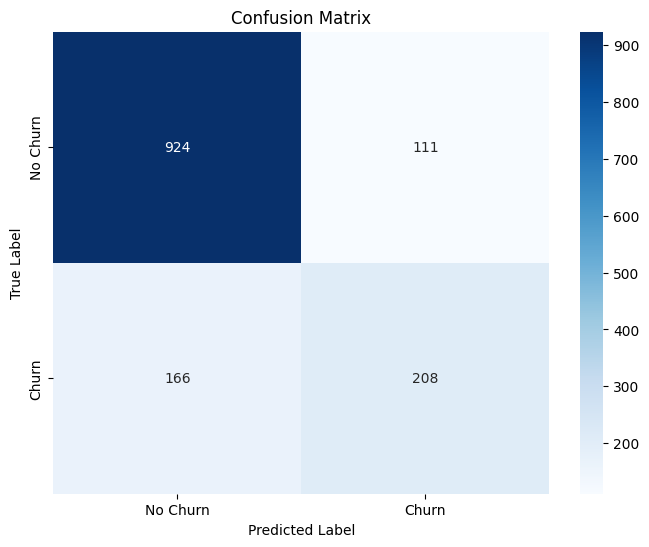

Matriz de confusión generada y mostrada.


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Matriz de confusión generada y mostrada.")

## Visualizar Curva ROC

### Subtask:
Calcular la Curva ROC (Receiver Operating Characteristic) y el Área Bajo la Curva (AUC), y luego graficar la curva ROC para evaluar la capacidad de discriminación del modelo.


**Reasoning**:
To begin visualizing the ROC curve, I need to import the necessary functions, `roc_curve` and `auc`, from `sklearn.metrics` as specified in the instructions.



In [21]:
from sklearn.metrics import roc_curve, auc

print("Funciones roc_curve y auc importadas con éxito.")

Funciones roc_curve y auc importadas con éxito.


**Reasoning**:
Now that the necessary functions are imported, I will calculate the ROC curve and AUC, and then plot the ROC curve as instructed. This involves computing false positive rates, true positive rates, and thresholds, and then visualizing them with `matplotlib.pyplot`.



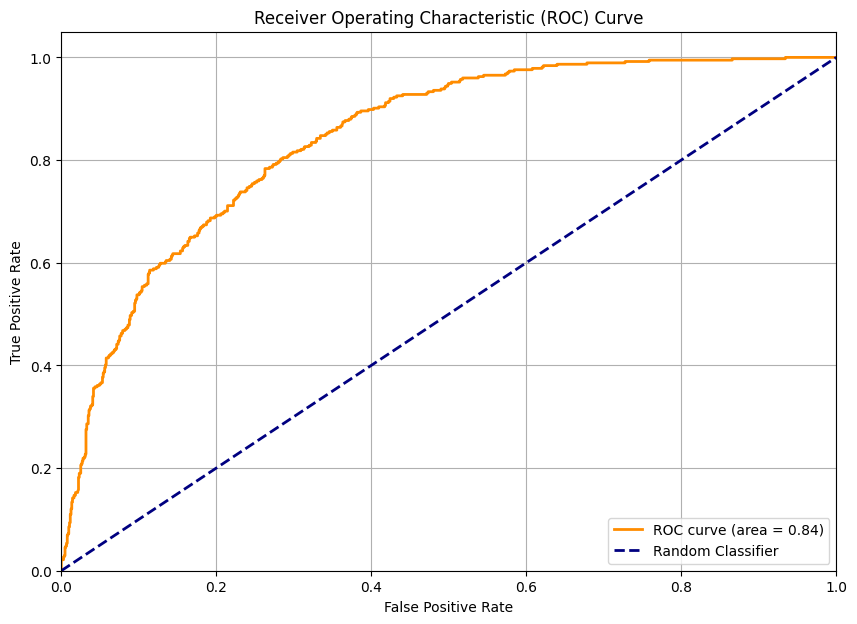

Curva ROC y AUC calculadas y graficadas.


In [22]:
import matplotlib.pyplot as plt

# Calcular la Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Curva ROC y AUC calculadas y graficadas.")

## Interpretar Coeficientes del Modelo

### Subtask:
Extraer los coeficientes del modelo de Regresión Logística y analizarlos para entender la importancia de cada característica en la predicción del abandono de clientes. Se mostrarán los coeficientes de forma interpretativa.


**Reasoning**:
To interpret the model, I will extract the coefficients from the trained Logistic Regression model and their corresponding feature names from the training data. This will allow us to create a DataFrame to easily visualize and analyze the importance of each feature.



In [23]:
coefficients = model.coef_[0]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Coeficientes del modelo de Regresión Logística, ordenados por importancia (valor absoluto):")
print(coef_df.drop(columns=['Abs_Coefficient']))

Coeficientes del modelo de Regresión Logística, ordenados por importancia (valor absoluto):
                                    Feature  Coefficient
4                                    tenure    -1.219673
18                       InternetService_No    -1.109138
21                        Contract_Two year    -0.980411
5                              PhoneService    -0.570824
15                             TotalCharges     0.493682
17              InternetService_Fiber optic     0.491154
7                            OnlineSecurity    -0.423834
19                  Contract_Month-to-month     0.375088
10                              TechSupport    -0.373786
23    PaymentMethod_Credit card (automatic)    -0.370328
13                         PaperlessBilling     0.369413
22  PaymentMethod_Bank transfer (automatic)    -0.340060
20                        Contract_One year    -0.325566
16                      InternetService_DSL    -0.312905
6                             MultipleLines     0.283

## Finalizar la Evaluación del Modelo

### Subtask:
Proporcionar un resumen completo de los resultados de la evaluación del modelo, incluyendo las métricas clave, las visualizaciones y las principales interpretaciones obtenidas de la importancia de las características.


## Summary:

### Q&A
The model evaluation provides a comprehensive summary of its performance in predicting customer churn, including key metrics, visualizations, and interpretations of feature importance.

### Data Analysis Key Findings

*   **Model Performance Metrics**: The Logistic Regression model achieved an Accuracy of 0.8034, an F1-score of 0.6003, Precision of 0.6520, Recall of 0.5561, and a ROC-AUC score of 0.8422.
*   **Confusion Matrix**: The model successfully generated a confusion matrix, showing the distribution of true positive, true negative, false positive, and false negative predictions, providing a visual representation of the classification performance.
*   **ROC Curve**: A Receiver Operating Characteristic (ROC) curve was plotted with an Area Under the Curve (AUC) matching the calculated 0.84, indicating good discrimination capability between churn and non-churn classes.
*   **Feature Importance**:
    *   **Strongest Negative Impact on Churn (Reduces Churn Probability)**:
        *   `tenure`: coefficient of -1.2197, indicating that longer tenure is associated with a lower probability of churn.
        *   `InternetService_No`: coefficient of -1.1091, suggesting customers without internet service are less likely to churn.
        *   `Contract_Two year`: coefficient of -0.9804, showing that customers with two-year contracts are significantly less likely to churn.
    *   **Strongest Positive Impact on Churn (Increases Churn Probability)**:
        *   `TotalCharges`: coefficient of 0.4937, implying that higher total charges correlate with an increased likelihood of churn.
        *   `InternetService_Fiber optic`: coefficient of 0.4912, suggesting customers with fiber optic internet are more prone to churn.
    *   Features like `gender` (0.0189) and `MonthlyCharges` (0.0040) showed minimal influence on churn probability.

### Insights or Next Steps

*   The model highlights key drivers of churn. Marketing and customer retention strategies should focus on customers with shorter tenure, those with fiber optic internet, and those not on two-year contracts.
*   Further investigation into the `TotalCharges` and `InternetService_Fiber optic` features could reveal underlying issues or opportunities to reduce churn. For example, high total charges might indicate dissatisfaction with pricing, and fiber optic issues could point to service quality problems.
